In [21]:
# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

pd.options.display.float_format = '{:,.2f}'.format

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

import PortfolioLab as pl
import investpy

def compute_portfolio_with_contributions(df, weights, start_value=100):
    start = df.index[0]
    Contribuição_diária_individual_all = pd.DataFrame()

    # Start and End date for backtest
    start = df.index[0]
    end = df.index[-1]

    # Calculate the rebalancing days dates (including inception date)
    start_index = pd.date_range(start=start, end=start, periods=1)
    end_index = pd.date_range(start=end, end=end, periods=1)    
    rebalancing_days = pd.date_range(start=start, end=end, freq='A').union(start_index)
    
    if end_index not in rebalancing_days:
        rebalancing_days = rebalancing_days.union(end_index)

    weights = weights
    n_assets = len(weights)
    start_value = start_value
    active_weights = weights.copy()


    for i in range(1, len(rebalancing_days)):

        # Select period between rebalances
        quotes = df[rebalancing_days[i-1]:rebalancing_days[i]]

        n_days = len(quotes)

        Evolução = quotes / quotes.iloc[0]
        
        UPs = np.tile(active_weights, n_days)        
        UPs.shape = (n_days, n_assets)
        UPs = pd.DataFrame(UPs)
        UPs.columns = quotes.columns
        UPs = UPs * 100    
        UPs.set_index(quotes.index, inplace=True)

        Evolução_no_portfolio = Evolução.mul(UPs, axis=1)

        Contribuição_do_dia = Evolução_no_portfolio - Evolução_no_portfolio.shift(1)

        Contribuição_diária_individual_all = pd.concat([Contribuição_diária_individual_all, Contribuição_do_dia.dropna()])

        Contribuição_no_portfolio = Contribuição_do_dia.cumsum()

        Portfolio = pd.DataFrame(Contribuição_diária_individual_all.dropna().cumsum().sum(axis=1)) + 100

        active_weights = (weights * np.repeat(Portfolio.iloc[-1][0], len(active_weights))) / 100
        
    Contribuição_individual = Contribuição_diária_individual_all.cumsum()    
    Contribuição_individual = Contribuição_individual[Contribuição_individual.index.dayofweek < 5]
    
    Portfolio.columns = ['Portfolio']
    Portfolio = Portfolio[Portfolio.index.dayofweek < 5]
    
    # Add initial day to portfolio   
    inicial_day_portfolio = pd.DataFrame({'Portfolio':[100]}, index=[start])
    Portfolio = pd.concat([inicial_day_portfolio, Portfolio])
    
    # Add initial day to Contribuição_individual
    ic_array = np.repeat(0, len(df.columns))
    inicial_day_ci = pd.DataFrame([ic_array], index=[start])
    inicial_day_ci.columns=df.columns
    Contribuição_individual = pd.concat([inicial_day_ci, Contribuição_individual])
    
    return Portfolio, Contribuição_individual

In [22]:
# pl.search_investing_etf(isins=['IE00BKPSFC54'])

In [23]:
%%capture
# "Normal"
IWDA = investpy.get_etf_historical_data(etf='iShares Core MSCI World UCITS',
                                      from_date='01/01/2000',
                                      to_date='01/01/2022',
                                      country='netherlands')[['Close']]

IWDA.columns=['IWDA']

# Momentum
IS3R = investpy.get_etf_historical_data(etf='iShares MSCI World Momentum Factor UCITS',
                                      from_date='01/01/2000',
                                      to_date='01/01/2022',
                                      country='germany')[['Close']]

IS3R.columns=['Momentum']

# Quality
IS3Q = investpy.get_etf_historical_data(etf='iShares MSCI World Quality Factor UCITS',
                                      from_date='01/01/2000',
                                      to_date='01/01/2022',
                                      country='germany')[['Close']]

IS3Q.columns=['Quality']

# Value
IS3S = investpy.get_etf_historical_data(etf='iShares MSCI World Value Factor UCITS',
                                      from_date='01/01/2000',
                                      to_date='01/01/2022',
                                      country='germany')[['Close']]

IS3S.columns=['Value']

# Volatility
IQQ0 = investpy.get_etf_historical_data(etf='iShares Edge MSCI World Min Vol',
                                      from_date='01/01/2000',
                                      to_date='01/01/2022',
                                      country='germany')[['Close']]

IQQ0.columns=['Volatility']

# Size
IS3T = investpy.get_etf_historical_data(etf='iShares MSCI World Size Factor UCITS',
                                      from_date='01/01/2000',
                                      to_date='01/01/2022',
                                      country='germany')[['Close']]

IS3T.columns=['Size']

In [24]:
ETFs = pl.merge_time_series(IWDA, IS3R, how='inner')
ETFs = pl.merge_time_series(ETFs, IS3Q, how='inner')
ETFs = pl.merge_time_series(ETFs, IS3S, how='inner')
ETFs = pl.merge_time_series(ETFs, IQQ0, how='inner')
ETFs = pl.merge_time_series(ETFs, IS3T, how='inner')

ETFs = pl.normalize(ETFs)

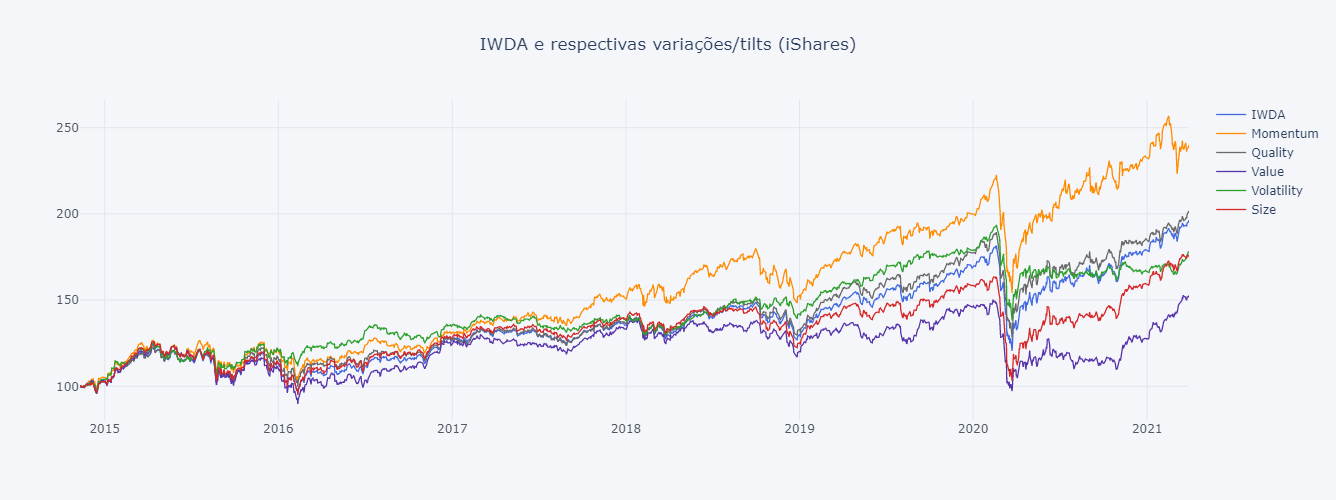

In [48]:
pl.ichart(round(ETFs, 2), 'IWDA vs Factors (iShares)', colab=False)

In [26]:
pl.compute_performance_table(ETFs)

**Performance from 2014-11-10 to 2021-03-30 (≈ 6.4 years)**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
IWDA,11.14%,96.40%,17.28%,0.64,-33.64%,0.33
Momentum,14.68%,140.07%,18.11%,0.81,-30.76%,0.48
Quality,11.61%,101.78%,16.99%,0.68,-32.30%,0.36
Value,6.85%,52.76%,18.76%,0.37,-35.17%,0.19
Volatility,9.41%,77.66%,14.23%,0.66,-28.65%,0.33
Size,9.28%,76.38%,17.52%,0.53,-36.85%,0.25


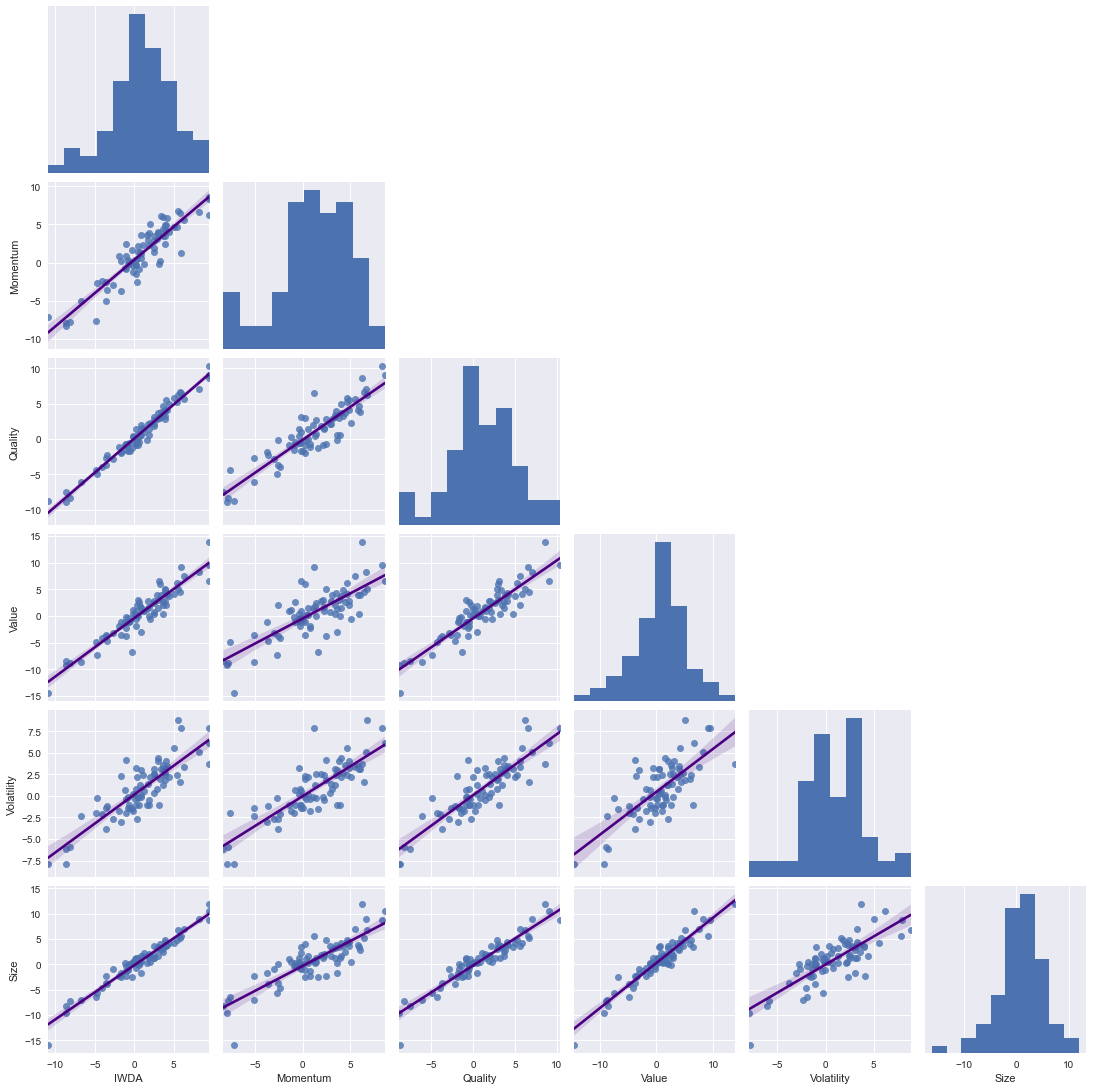

In [27]:
import seaborn as sns
returns_M = ETFs.resample('M').last().pct_change().dropna() * 100
ax = sns.pairplot(returns_M, corner=True, kind="reg", plot_kws={'line_kws':{'color':'indigo'}})
ax;

### Correlação de retornos mensais

In [28]:
returns_M.corr()

,IWDA,Momentum,Quality,Value,Volatility,Size
IWDA,1.00,0.91,0.98,0.94,0.84,0.97
Momentum,0.91,1.00,0.91,0.77,0.83,0.85
Quality,0.98,0.91,1.00,0.91,0.87,0.95
Value,0.94,0.77,0.91,1.00,0.73,0.95
Volatility,0.84,0.83,0.87,0.73,1.00,0.80
Size,0.97,0.85,0.95,0.95,0.80,1.00


### R Quadrados

In [29]:
pl.compute_r2_table(returns_M[['IWDA']], returns_M[['Quality']])

,IWDA
Quality,0.97


In [30]:
pl.compute_r2_table(returns_M[['Volatility']], returns_M[['Value']])

,Volatility
Value,0.54


In [31]:
import statsmodels.api as sm

In [32]:
# Helper functions
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which you can call
       .summary() to print a full summary
       .params for the coefficients
       .tvalues and .pvalues for the significance levels
       .rsquared_adj and .rsquared for quality of fit
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1
    
    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm.params

def compute_rsa(quotes, normalized_results=False):
    '''
    quotes is a dataframe of quotes where the first column is
    the dependent variable
    '''
    dependent_variable = quotes.iloc[:, 0].pct_change().dropna()
    independent_variables = quotes.iloc[:, 1:].pct_change().dropna()

    values = regress(dependent_variable=dependent_variable,
                    explanatory_variables=independent_variables,
                    alpha=False)
    
    if normalized_results==True:
        values = values / values.sum()
    
    return values

In [33]:
ETFs.head()

,IWDA,Momentum,Quality,Value,Volatility,Size
Date,,,,,,
2014-11-10,100.00,100.00,100.00,100.00,100.00,100.00
2014-11-11,100.03,100.10,100.14,100.25,100.19,100.24
2014-11-12,99.55,99.76,99.95,99.55,99.92,99.90
2014-11-13,99.64,99.52,99.81,99.65,100.27,99.80
2014-11-14,99.58,99.47,99.76,99.75,100.04,99.95


In [34]:
compute_rsa(ETFs, normalized_results=True)

Momentum     0.18
Quality      0.47
Value        0.18
Volatility   0.02
Size         0.15
dtype: float64

In [42]:
portfolio = pl.compute_portfolio(quotes=ETFs, weights=[0, 0.18, 0.47, 0.18, 0.02, 0.15])

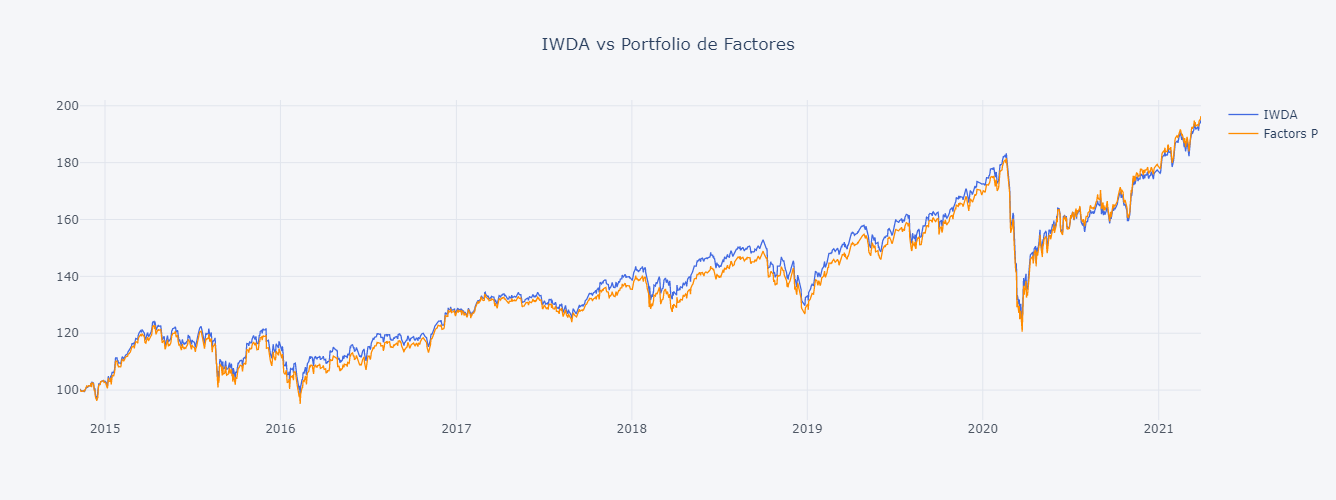

In [53]:
IWDA_and_factors_p = pl.normalize(pl.merge_time_series(portfolio, IWDA, 'inner'))
IWDA_and_factors_p.columns=['IWDA', 'Factors P']
pl.ichart(IWDA_and_factors_p, title='IWDA vs Portfolio de Factores', colab=False)

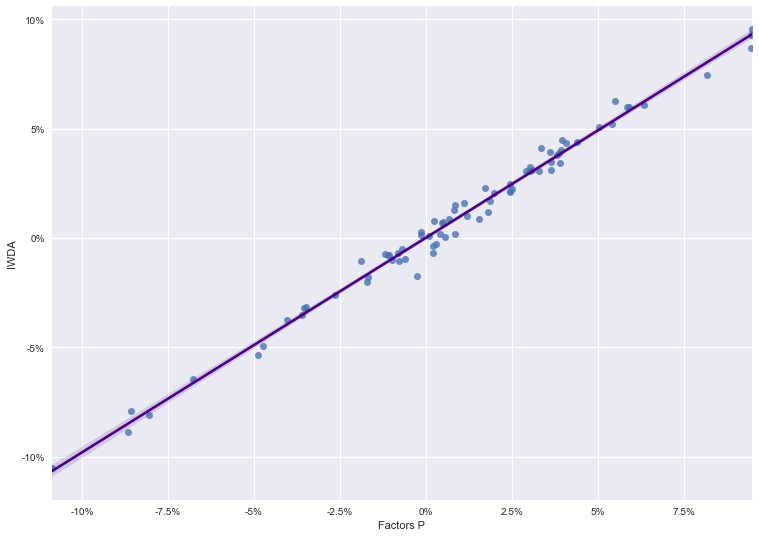

In [44]:
IWDA_and_factors_p_ret = IWDA_and_factors_p.resample('M').last().pct_change().dropna()

chart = sns.lmplot(data=IWDA_and_factors_p_ret, x="Factors P", y="IWDA", line_kws={'color': 'indigo'})
chart.fig.set_figwidth(12)
chart.fig.set_figheight(8)
chart.set(yticklabels=['', '-10%', '-5%', '0%', '5%', '10%']);
chart.set(xticklabels=['', '-10%', '-7.5%', '-5%', '-2.5%', '0%', '2.5%', '5%', '7.5%']);

In [45]:
pl.compute_r2_table(IWDA_and_factors_p_ret[['Factors P']], IWDA_and_factors_p_ret[['IWDA']])

,Factors P
IWDA,0.99


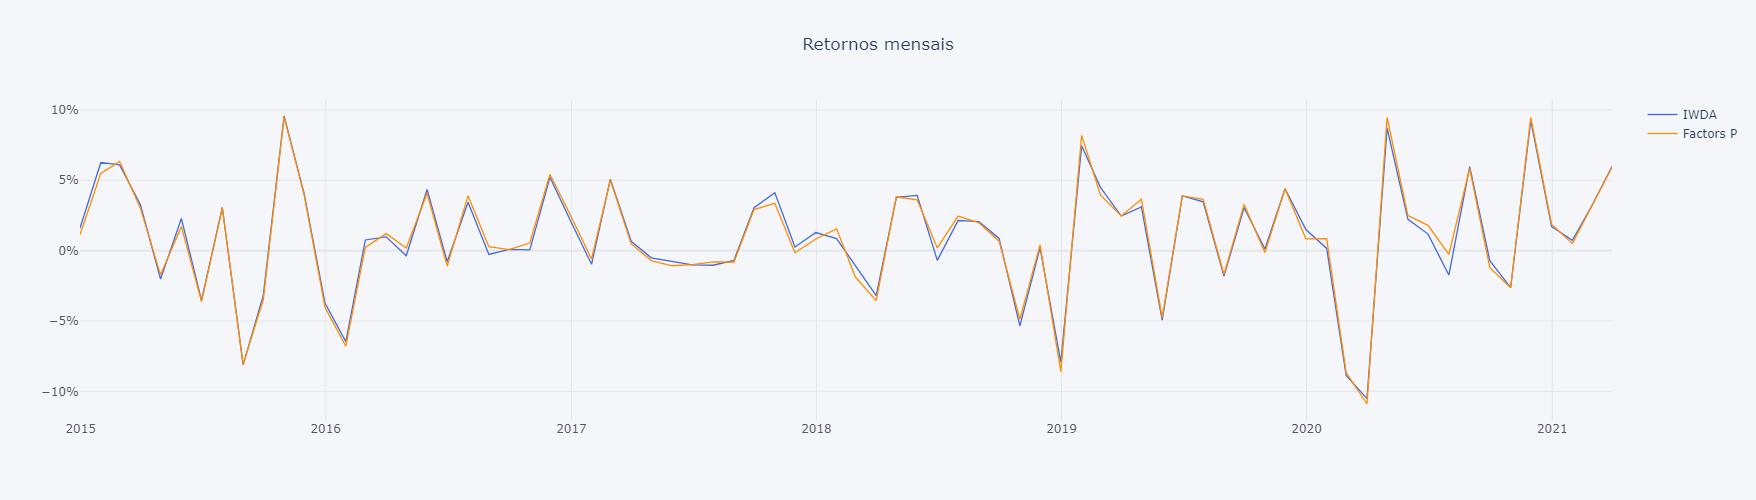

In [54]:
pl.ichart(IWDA_and_factors_p_ret * 100, colab=False, title='Retornos mensais', yticksuffix='%')

In [47]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [ ]:
# Fazer um rátio